# Reweighting using GBT

We will load the kaggle agreement data, which has both real and simulated data which differ. The real data is sPloted. We will try to make the distributions be equal for a classifier by changing the weights of the simulated distribution.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sbs

from hep_ml import reweight

import lightgbm as lgb

from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.model_selection import StratifiedKFold

%matplotlib inline
np.random.seed(2210)

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
path = '../../Data/kaggleFlavorPhysics/'
data = pd.read_csv(path+'check_agreement.csv',index_col='id')
data.head()

,LifeTime,dira,FlightDistance,FlightDistanceError,IP,IPSig,VertexChi2,pt,DOCAone,DOCAtwo,...,p2_pt,p0_p,p1_p,p2_p,p0_eta,p1_eta,p2_eta,SPDhits,signal,weight
id,,,,,,,,,,,,,,,,,,,,,
15347063,0.001451,0.999964,6.945030,0.229196,0.058117,2.961298,7.953543,2251.611816,0.082219,0.084005,...,834.562378,10392.814453,6380.673828,15195.594727,2.666142,3.302978,3.594246,512,0,-0.307813
14383299,0.000679,0.999818,9.468235,0.517488,0.189683,14.413060,7.141451,10594.470703,0.007983,0.044154,...,2861.309814,3174.356934,64480.023438,23134.953125,2.995265,2.834816,2.779366,552,0,-0.331421
7382797,0.003027,0.999847,13.280714,0.219291,0.231709,11.973175,4.778880,2502.196289,0.045085,0.106614,...,932.128235,15219.761719,3921.181641,10180.791016,2.776633,3.204923,3.081832,318,0,-0.382215
6751065,0.000810,0.999998,5.166821,0.167886,0.011298,0.891142,5.528002,5097.813965,0.055115,0.038642,...,2617.248291,4365.082520,13221.149414,24291.875000,2.179345,2.769762,2.918251,290,0,1.465194
9439580,0.000706,0.999896,10.897236,0.284975,0.160511,16.367550,8.670339,20388.097656,0.015587,0.020872,...,4763.682617,27463.011719,46903.394531,24241.628906,2.196114,2.262732,2.310401,45,0,-0.477084


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331147 entries, 15347063 to 11408078
Data columns (total 48 columns):
LifeTime               331147 non-null float64
dira                   331147 non-null float64
FlightDistance         331147 non-null float64
FlightDistanceError    331147 non-null float64
IP                     331147 non-null float64
IPSig                  331147 non-null float64
VertexChi2             331147 non-null float64
pt                     331147 non-null float64
DOCAone                331147 non-null float64
DOCAtwo                331147 non-null float64
DOCAthree              331147 non-null float64
IP_p0p2                331147 non-null float64
IP_p1p2                331147 non-null float64
isolationa             331147 non-null int64
isolationb             331147 non-null int64
isolationc             331147 non-null int64
isolationd             331147 non-null float64
isolatione             331147 non-null float64
isolationf             331147 non-null f

We select 5 different variables and plot them to see the difference between real and Monte-Carlo simulated data.

In [4]:
columns = ['VertexChi2','SPDhits','FlightDistance','p0_track_Chi2Dof', 'p1_track_Chi2Dof']
#columns = ["IPSig","SPDhits",'p0_track_Chi2Dof', 'p1_track_Chi2Dof']
columns

['VertexChi2',
 'SPDhits',
 'FlightDistance',
 'p0_track_Chi2Dof',
 'p1_track_Chi2Dof']

Initial distributions:

In [6]:
plt.rcParams['figure.figsize'] = [10, 6]
font_size = 24

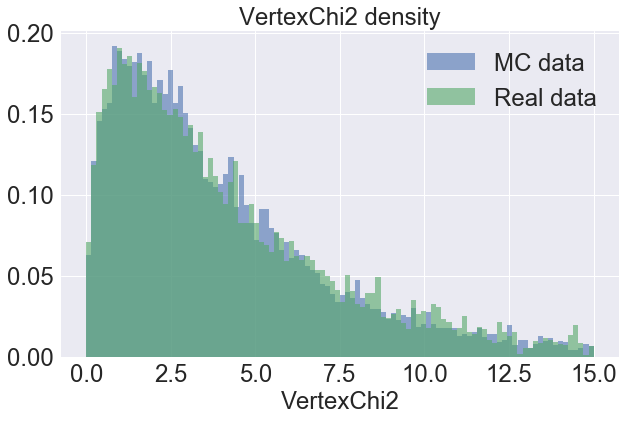

In [7]:
plt.hist(data['VertexChi2'][data['signal']==1],bins=100,
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['VertexChi2'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('VertexChi2',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('VertexChi2 density',fontsize=font_size)
plt.savefig('ReweightBefore1.pdf')

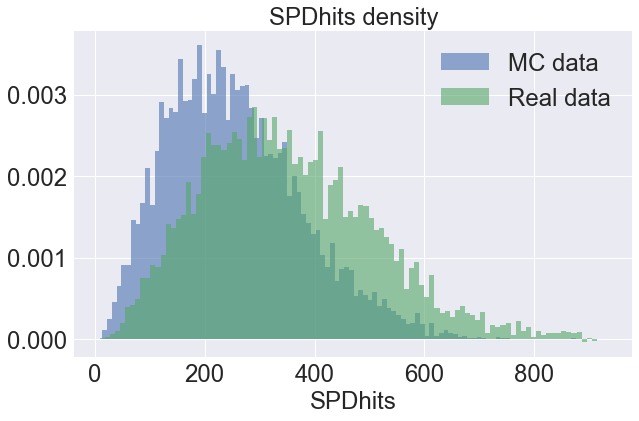

In [8]:
plt.hist(data['SPDhits'][data['signal']==1],bins=100,
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['SPDhits'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('SPDhits',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('SPDhits density',fontsize=font_size)
plt.savefig('ReweightBefore2.pdf')

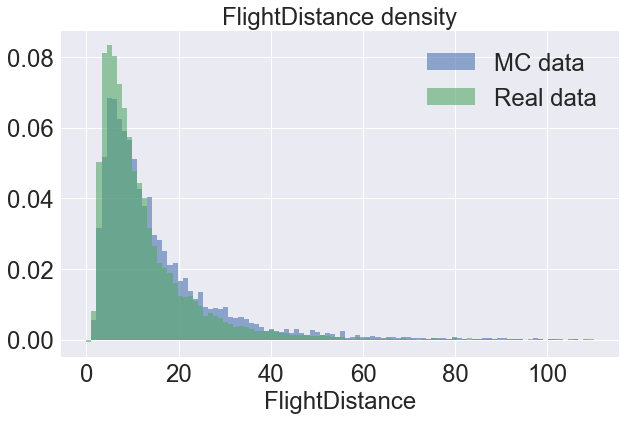

In [9]:
plt.hist(data['FlightDistance'][data['signal']==1],bins=100,
         label='MC data',normed=True,alpha=0.6,range=[0,110])
plt.hist(data['FlightDistance'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6,range=[0,110])
plt.tick_params(labelsize=font_size)
plt.xlabel('FlightDistance',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('FlightDistance density',fontsize=font_size)
plt.savefig('ReweightBefore3.pdf')

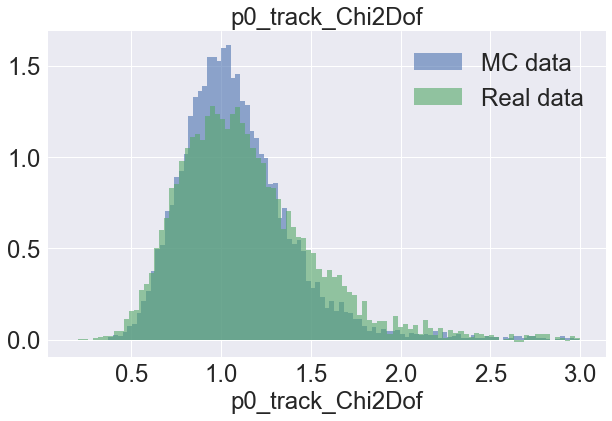

In [10]:
plt.hist(data['p0_track_Chi2Dof'][data['signal']==1],bins=100,
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['p0_track_Chi2Dof'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('p0_track_Chi2Dof',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('p0_track_Chi2Dof',fontsize=font_size)
plt.savefig('ReweightBefore4.pdf')

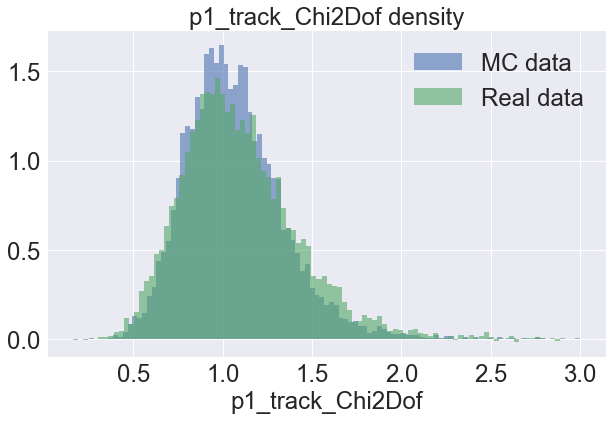

In [11]:
plt.hist(data['p1_track_Chi2Dof'][data['signal']==1],bins=100,
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['p1_track_Chi2Dof'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('p1_track_Chi2Dof',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('p1_track_Chi2Dof density',fontsize=font_size)
plt.savefig('ReweightBefore5.pdf')

We reweight using the `hep_ml` reweighter and plot the new distributions.

In [12]:
Xtrain = data[columns]
ytrain = data['signal']
Wtrain = data['weight']
ntrees = 700
reweighter = reweight.GBReweighter(n_estimators=ntrees, learning_rate=0.1,
                                   max_depth=4, min_samples_leaf=200,
                                   gb_args={'subsample': 0.6})
reweighter.fit(Xtrain[ytrain==1],Xtrain[ytrain==0],target_weight=Wtrain[ytrain==0])

GBReweighter(gb_args={'subsample': 0.6}, learning_rate=0.1, max_depth=4,
       min_samples_leaf=200, n_estimators=700)

In [13]:
gbweights = Wtrain.copy()
gbweights[ytrain==1] = reweighter.predict_weights(Xtrain[ytrain==1])

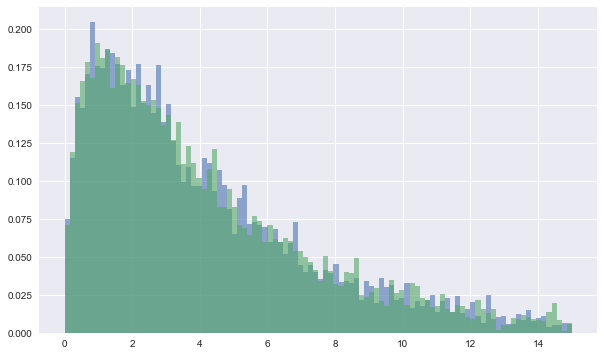

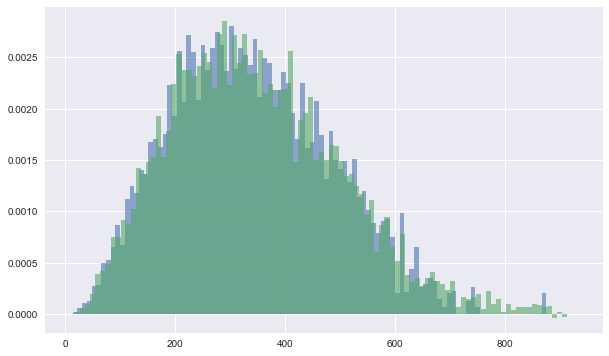

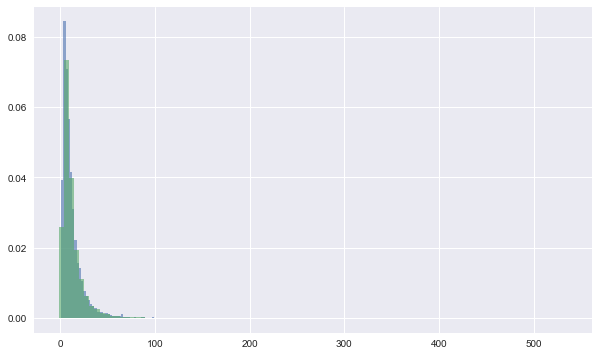

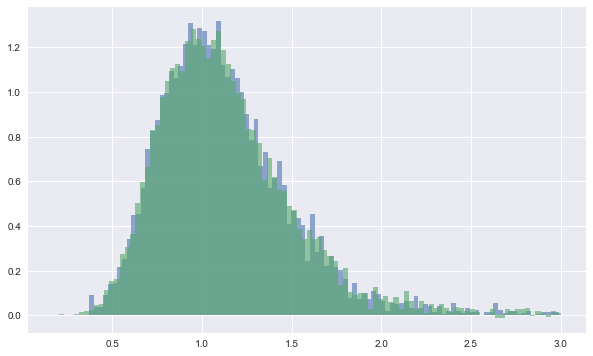

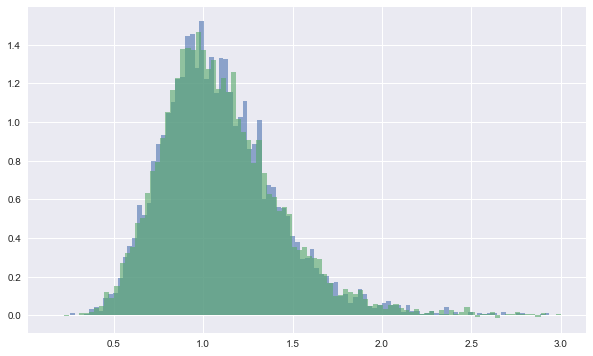

In [14]:
for column in columns:
    plt.hist(data[column][data['signal']==1],bins=100,
             weights=gbweights[ytrain==1],
             label='MC data',normed=True,alpha=0.6)
    plt.hist(data[column][data['signal']==0],bins=100,
             weights=data['weight'][data['signal']==0],
             label='Real data',normed=True,alpha=0.6)
    plt.show()

We now train a classifier trying to distinguish the classes both before reweighting and with the new weights, computing the roc score.

In [15]:
weights = {}
weights['original'] = Wtrain
weights['gb_weights'] = gbweights

In [16]:
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'num_leaves': 7,
    'max_depth': 3,
    'is_unbalance': 'true',
    'learning_rate': .3,
    'num_threads': 4,
    'min_data_in_leaf': 100
}

In [28]:
predicts = []
for name, new_weights in weights.items():
    dtrain = lgb.Dataset(Xtrain,ytrain,weight=new_weights)
    gbm = lgb.train(params, dtrain, 
                    num_boost_round=100)
    predicts.append(gbm.predict(Xtrain))
    print(name, roc_auc_score(ytrain, predicts[-1],sample_weight=new_weights))

gb_weights 0.551859650686
original 0.734867694303


original 0.734867694303
gb_weights 0.562372949126

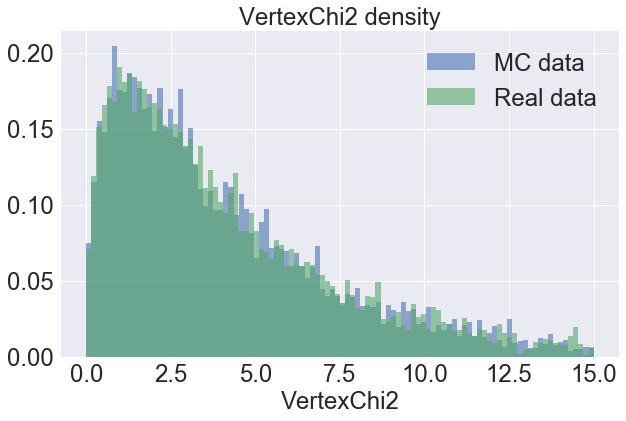

In [18]:
plt.hist(data['VertexChi2'][data['signal']==1],bins=100,
         weights = gbweights[ytrain==1],
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['VertexChi2'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('VertexChi2',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('VertexChi2 density',fontsize=font_size)
plt.savefig('ReweightAfter1.pdf')

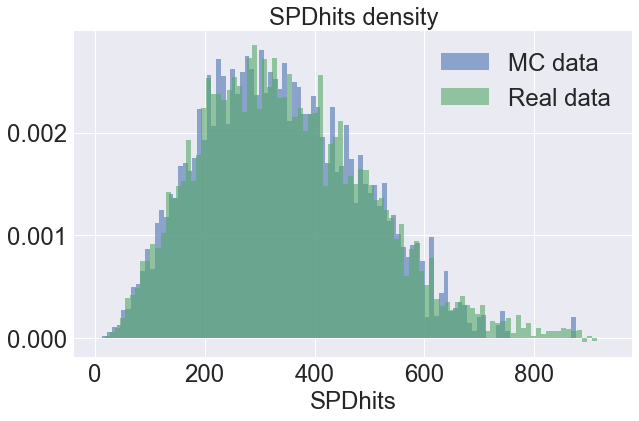

In [19]:
plt.hist(data['SPDhits'][data['signal']==1],bins=100,
         weights = gbweights[ytrain==1],
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['SPDhits'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('SPDhits',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('SPDhits density',fontsize=font_size)
plt.savefig('ReweightAfter2.pdf')

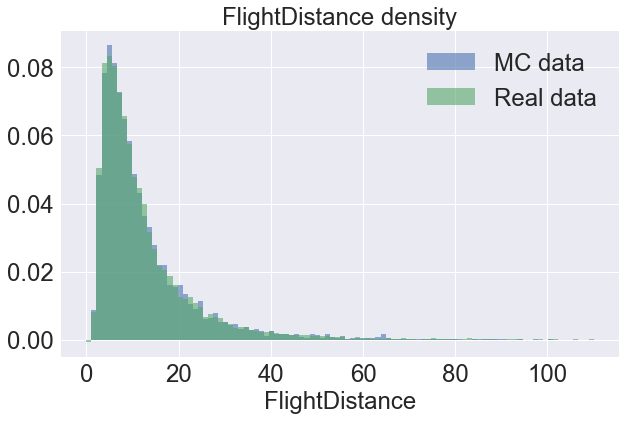

In [20]:
plt.hist(data['FlightDistance'][data['signal']==1],bins=100,
         weights = gbweights[ytrain==1],
         label='MC data',normed=True,alpha=0.6,range=[0,110])
plt.hist(data['FlightDistance'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6,range=[0,110])
plt.tick_params(labelsize=font_size)
plt.xlabel('FlightDistance',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('FlightDistance density',fontsize=font_size)
plt.savefig('ReweightAfter3.pdf')

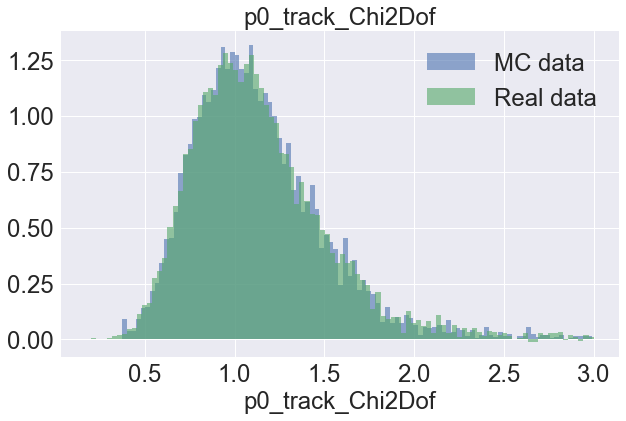

In [21]:
plt.hist(data['p0_track_Chi2Dof'][data['signal']==1],bins=100,
         weights = gbweights[ytrain==1],
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['p0_track_Chi2Dof'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('p0_track_Chi2Dof',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('p0_track_Chi2Dof',fontsize=font_size)
plt.savefig('ReweightAfter4.pdf')

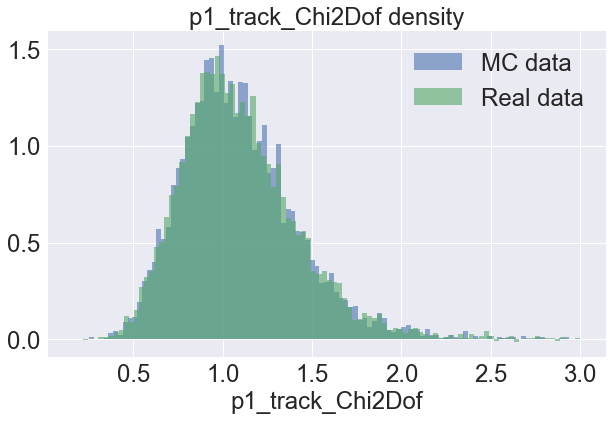

In [22]:
plt.hist(data['p1_track_Chi2Dof'][data['signal']==1],bins=100,
         weights = gbweights[ytrain==1],
         label='MC data',normed=True,alpha=0.6)
plt.hist(data['p1_track_Chi2Dof'][data['signal']==0],bins=100,
         weights=data['weight'][data['signal']==0],
         label='Real data',normed=True,alpha=0.6)
plt.tick_params(labelsize=font_size)
plt.xlabel('p1_track_Chi2Dof',fontsize=font_size)
plt.legend(fontsize=font_size)
plt.title('p1_track_Chi2Dof density',fontsize=font_size)
plt.savefig('ReweightAfter5.pdf')

We now show the ROC curve and the ROC auc score of both cases.

In [30]:
from sklearn.metrics import roc_curve, auc

In [35]:
fpr = dict()
tpr = dict()
roc_auc = dict()
i=0
for name, new_weights in weights.items():
    fpr[i], tpr[i], _ = roc_curve(ytrain, predicts[i],sample_weight=new_weights)
    roc_auc[i] = auc(fpr[i], tpr[i],reorder=True)
    i = i+1
roc_auc

{0: 0.55185965068638998, 1: 0.73486769430321852}

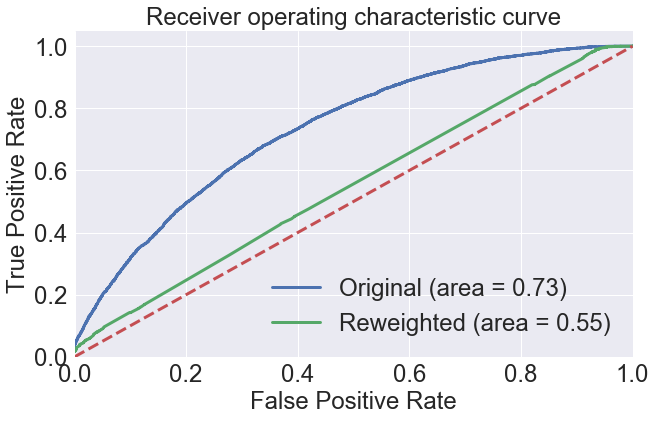

In [53]:
plt.figure()
lw = 3
plt.plot(fpr[1], tpr[1], 
         lw=lw, label='Original (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[0], tpr[0], 
         lw=lw, label='Reweighted (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1],  lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.tick_params(labelsize=font_size)
plt.xlabel('False Positive Rate',fontsize=font_size)
plt.ylabel('True Positive Rate',fontsize=font_size)
plt.title('Receiver operating characteristic curve',fontsize=font_size)
plt.legend(loc="lower right",fontsize=font_size)
plt.savefig('ReweightROC.pdf');

In [57]:
from hep_ml.metrics_utils import ks_2samp_weighted
for column in columns:
    print('No reweight KS over ', column, ' = ', ks_2samp_weighted(Xtrain[column][ytrain==0], Xtrain[column][ytrain==1], 
                                         weights1=Wtrain[ytrain==0], 
                                         weights2=Wtrain[ytrain==1]))
    print('Reweigthed KS over ', column, ' = ', ks_2samp_weighted(Xtrain[column][ytrain==0], Xtrain[column][ytrain==1], 
                                         weights1=gbweights[ytrain==0], 
                                         weights2=gbweights[ytrain==1]))

No reweight KS over  VertexChi2  =  0.023082231108
Reweigthed KS over  VertexChi2  =  0.00776930489838
No reweight KS over  SPDhits  =  0.258060741362
Reweigthed KS over  SPDhits  =  0.018518172017
No reweight KS over  FlightDistance  =  0.107384212755
Reweigthed KS over  FlightDistance  =  0.00673374810714
No reweight KS over  p0_track_Chi2Dof  =  0.0763301747079
Reweigthed KS over  p0_track_Chi2Dof  =  0.00766468735642
No reweight KS over  p1_track_Chi2Dof  =  0.0567296215025
Reweigthed KS over  p1_track_Chi2Dof  =  0.00891104469161
